In [6]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
import scipy
from scipy import stats
#import matplotlib.colors as mcolorsxx

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
import databuilder.data_loader as data_loader
from trainer.trainer import Trainer
from model.build_model import TorchModel
from base.base_model import BaseModel
from utils import utils
from shash.shash_torch import Shash
# import databuilder.nino_indices as nino_indices # CAUSES CELL TO HANG

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.26.4
xarray version = 2024.2.0
pytorch version = 2.1.2.post2


In [7]:
config = utils.get_config("exp006")
seed = config["seed_list"][0]

In [8]:
# Setup the Data
front_cutoff = config["databuilder"]["front_cutoff"] # remove front nans : 74 ENSO - two front nans before daily interpolation = 60 days, daily interpolation takes 1/2 the original time step = 15 days TOTAL = ~75
back_cutoff = config["databuilder"]["back_cutoff"]  # remove back nans 

trainset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_train.pkl", front_cutoff, back_cutoff)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_val.pkl", front_cutoff, back_cutoff)
testset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_test.pkl", front_cutoff, back_cutoff)

X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)


In [9]:
# Prepare Model and Target Data

# Open Model Outputs
model_output_pred = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_pred_testset.pkl'
with gzip.open(model_output_pred, "rb") as obj1:
    output = pickle.load(obj1)

# Open Target Data (test set)
target_file = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'
with gzip.open(target_file, "rb") as obj1:
    test_target = pickle.load(obj1)

test_target = test_target["y"][front_cutoff : -back_cutoff]

# SHORTEN SAMPLES FOR SPEED: 
# output = output[30000:40000, :]
# test_target = test_target[30000:40000]

In [10]:
samples_size = 20000

crps_lower = Shash(output[:samples_size, :]).cdf_NONTENSOR(output[:samples_size,:], test_target[:samples_size]) # area under SHASH CDF up until target value
#print(crps_lower)

dist = Shash(output[:samples_size, :])
p = dist.prob(test_target[:samples_size]).numpy()

maxP = np.zeros(samples_size)
CRPS = np.zeros(samples_size)

for idist, distribution in enumerate(p):
    maxP[idist] = p.max()
            # heaviside - (1- crps_lower) = (x_inf - x) - (1 - crps_lower) = x_delta - (1 - crps_lower)
    crps_upper =  maxP[idist] - (1 - crps_lower[idist]) # area between heaviside function and SHASH CDF 

    CRPS[idist] =  (crps_lower[idist] + crps_upper) ** 2

Climatologial Mean = 0.00018667661056060916
(960, 60058)


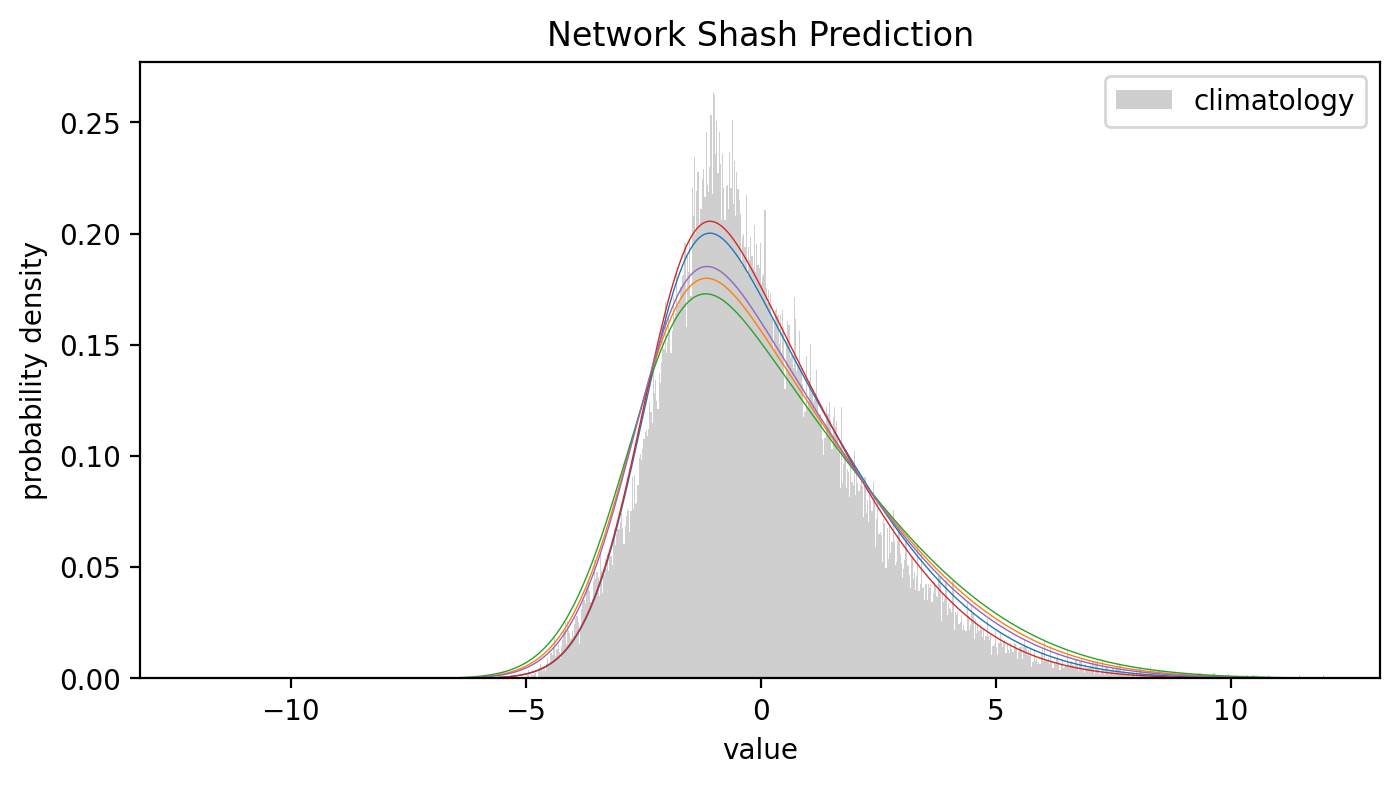

In [12]:
samples = [18213, 290, 6090, 17, 1998]

# samples = [37, 2052, 12209, 9704, 18046]
#samples = np.linspace(1, 59000, 50).astype(int)

x = np.arange(-12, 12, 0.025)

cfile = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'

with gzip.open(cfile, "rb") as obj1:
    data = pickle.load(obj1)
    climatology = data["y"]

print(f"Climatologial Mean = {np.mean(climatology)}")
    
dist = Shash(output)
p = dist.prob(x).numpy()

print(p.shape)

plt.figure(figsize=(8, 4), dpi=200)
plt.hist(
    climatology, x, density=True, color="silver", alpha=0.75, label="climatology"
)

plt.plot(x, p[:, samples], linewidth = 0.5 ) #label = samples
plt.xlabel("value")
plt.ylabel("probability density")
plt.title("Network Shash Prediction")
plt.legend()
#plt.savefig('/Users/C830793391/Documents/Research/E3SM/visuals/ens3/exp006_50_predictions_w_climatology.png', format='png', bbox_inches ='tight', dpi = 300)

In [13]:
print(test_target[samples])
print(CRPS[samples])

[ 1.34474912  3.86660336  4.17646555 -0.32000749 -0.21571092]
[0.54383442 1.19083184 1.21084048 0.06565504 0.07659957]


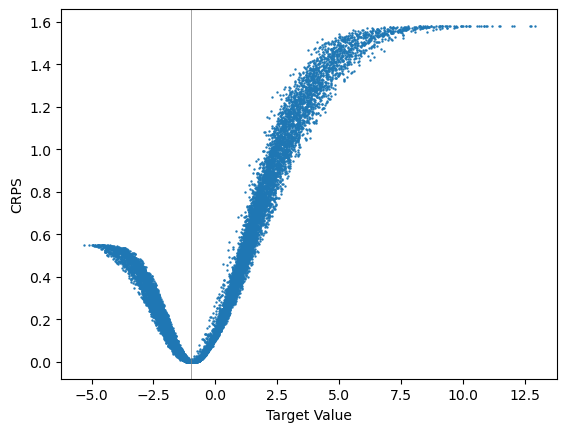

In [16]:
plt.figure()
plt.scatter(test_target[:samples_size], CRPS, s = 0.5)
plt.xlabel("Target Value")
plt.ylabel("CRPS")
plt.axvline(-1, color  = 'grey', linewidth = 0.5)